In [348]:
import tensorflow as tf
import tensorflow_addons as tfa

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [539]:
image = Image.open('pencil_portrait.jpg')
image = np.copy(np.asarray(image, dtype = float))[:,:,0]/255
image_shape = image.shape
image = np.expand_dims(image, axis = -1)
image_dataset = tf.data.Dataset.from_tensors(image)
image_dataset_flat = tf.data.Dataset.from_tensors(image.flatten())

image_dataset = tf.data.Dataset.zip((image_dataset, image_dataset_flat)).batch(1).repeat(1000)

In [669]:
def blur_image(a_image):
    a_image = a_image * 10 #To force the lines to not be drawn adjacently.
    a_image = tfa.image.gaussian_filter2d(a_image, filter_shape = [5, 1], padding = 'REFLECT')
    a_image = tf.clip_by_value(a_image, 0, 1)
    return a_image

def image_similarity(image_true, image_pred, image_shape):
    image_true = tf.reshape(image_true, image_shape)
    image_pred = tf.reshape(image_pred, image_shape)
    image_pred_smoothed = tfa.image.gaussian_filter2d(image_true, filter_shape = [5, 1])
    return tf.keras.losses.MSE(image_true, image_pred_smoothed)
    
def vertical_loss(image_true, image_pred):
    image_true_binary = image_true > 0.5
    curr_shape = (-1, *image_shape, 1)
    image_pred_rounded = tf.reshape(tf.cast(image_pred > 0.5, dtype=float), shape = curr_shape)
#     dx, dy = tf.image.image_gradients(image_pred_rounded)
#     dx, dy = abs(dx), abs(dy)
#     dx_loss, dy_loss = tf.reduce_sum(dx), tf.reduce_sum(dy)
#     image_similarity_loss = image_similarity(image_true, image_pred, curr_shape) 
#     x_change_penalty = - dx_loss/1000 
#     y_change_bonus = dy_loss/1000
#     return tf.keras.losses.MAE(image_true_binary, image_pred) +  x_change_penalty/10 + y_change_bonus/10
    freq_of_image = tf.cast(abs(tf.signal.rfft2d(image_pred_rounded)), tf.float32)
    

In [670]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 2, kernel_size = 3, padding = 'same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters = 2, kernel_size = 3, padding = 'same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters = 4, kernel_size = 3, padding = 'same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters = 4, kernel_size = 3, padding = 'same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters = 1, kernel_size = 1, padding = 'same'))
model.add(tf.keras.layers.Flatten())

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = vertical_loss) 

In [671]:
model.fit(image_dataset)

1000/1000 [==============================] - 33s 32ms/step - loss: 0.2672


In [672]:
binary_image = model.predict(np.asarray([image,]))
binary_image = np.reshape(binary_image, image_shape)

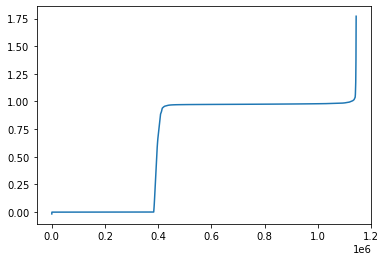

In [673]:
plt.plot(sorted(binary_image.flatten()))

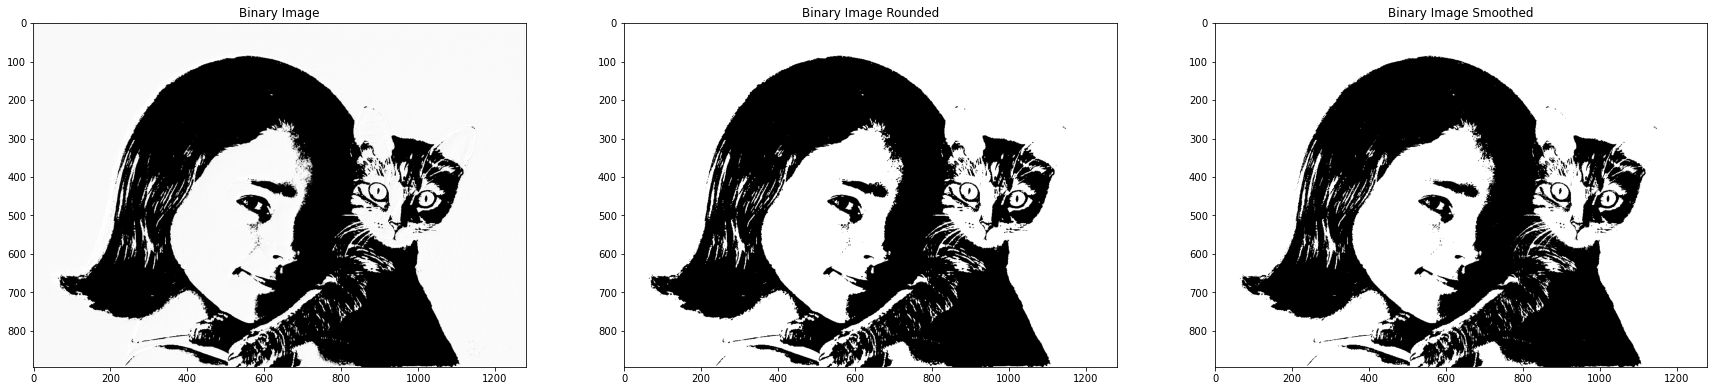

In [674]:
plt.figure(figsize = (30, 8))
rows = 1
cols = 3
i=0

i += 1
plt.subplot(rows, cols, i)
plt.title("Binary Image")
plt.imshow(np.squeeze(binary_image), 
           vmin = 0, 
           vmax = 1, 
           cmap = 'gray')

i += 1
plt.subplot(rows, cols, i)
plt.title("Binary Image Rounded")
plt.imshow(np.squeeze(np.round(binary_image)), 
           vmin = 0, 
           vmax = 1, 
           cmap = 'gray')

i += 1
plt.subplot(rows, cols, i)
plt.title("Binary Image Smoothed")
plt.imshow(np.squeeze(np.round(image)), vmin = 0, vmax = 1, cmap = 'gray')

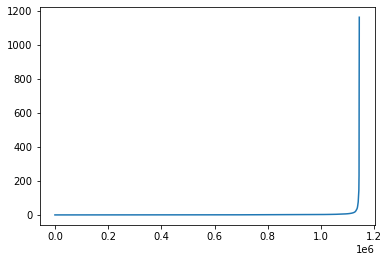

In [678]:
plt.plot(sorted(np.asarray(tf.cast(abs(tf.signal.rfft2d(image)), tf.float32)).flatten()))

(894, 1280)


AttributeError: 'Line2D' object has no property 'vmin'

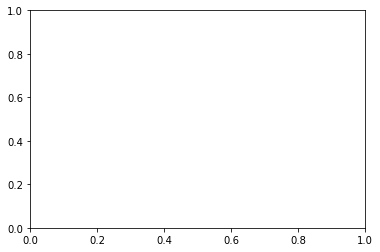

In [681]:
curr_img = np.squeeze(tf.cast(abs(tf.signal.rfft2d(image)), tf.float32))
print(curr_img.shape)
plt.plot(curr_img, vmin = 0, vmax = 200)